# <center>Read Keystroke Data and Build Model to Process</center>

In [1]:
import os
import copy
import string
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import svm
import sklearn.cross_validation

input_path = "Dataset/Kevin and Maxion/DSL-StrongPasswordData.csv"
print input_path;

Dataset/Kevin and Maxion/DSL-StrongPasswordData.csv


## Import Raw Data and Extract Features. Pre-process the data 

### Dataset (The CMU keystroke dynamics dataset)

* The CMU benchmark dataset contains keystroke dynamics consisting of the dwell time for each key and the latencies between two successive keys for static password string “.tie5Roanl”.
* For each subject, there were data collection sessions with at least one day apart between two sessions. 50 repeated keystroke strings were collected in each session, resulting in a total 400 sample for each subject.
* For each typed 10-letter password and the final enter key, the dwell time and diagraphs give rise to a 31 dimensional feature vector.

Although the keystroke features provide sufficiently distinguishing patterns for each subject, they are highly correlated, with large scale variations, and typical of noise and outliers. Someone has previously proposed a new distance metric to effectively handle these challenges that are intrinsic to keystroke dynamics data.

In [39]:
file = open(input_path, "r");

raw_data = file.read();
print type(raw_data);

data_lines = np.array(raw_data.splitlines());
print data_lines[0];

data = np.array([x.split(",") for x in data_lines]);
# data = np.delete(data, np.s_[31:34], 1); ## Delete the "Enter"'s information
data = np.delete(data, np.s_[31::1], 1);
data = np.delete(data, 0, 0); ## Delete the first line

# change username to index (0-50)
for i in range(len(data)):
    data[i][0] = i/400;

data = data.astype(np.float);

data = normalize(data, 3);
print data[0:10]

data_two = data[0:2*400];
data_user = np.array([data[i*400:(i+1)*400] for i in range(51)]);

print data.shape;
print data_user.shape; ## All the data organized by different users

<type 'str'>
subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,DD.i.e,UD.i.e,H.e,DD.e.five,UD.e.five,H.five,DD.five.Shift.r,UD.five.Shift.r,H.Shift.r,DD.Shift.r.o,UD.Shift.r.o,H.o,DD.o.a,UD.o.a,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
31
[[  0.00000000e+00   1.00000000e+00   1.00000000e+00   1.88089501e+00
    6.06506843e-01   3.44003825e-01   7.72068332e-01  -1.36373924e-02
   -1.81768436e-01   1.31422262e+00   2.72464082e-01   1.15943102e-01
    1.71576942e+00   3.05675812e+00   2.84416156e+00   1.73352760e+00
    4.48117633e+00   4.32735139e+00   3.17483982e-01   2.91115240e+00
    2.73829976e+00   5.01244006e-01   5.31832773e-01   4.00190086e-01
    7.37646761e-01  -2.11324612e-02  -2.93844664e-01   1.07385286e-01
    9.91226644e-01   9.12274942e-01   1.34794668e+00]
 [  0.00000000e+00   1.00000000e+00   2.00000000e+00   5.98188834e-01
    3.67081708e-01   2.78756912e-01  -5.95367077e-01  -3.30127393e-01
   -1.94491921e-

### Data Normalization
* From the begining, I think data here doesn't need to be normalized. Because the range of the value is small, and features' value is close to each other.
* In order to improve the accuracy of the model, we'd better try whether the normalization can bring us some improvement.

In [38]:
## Z-score normalization
def normalize(data, index):
    num_col = len(data[0]);
    print num_col;
    num_row = len(data);
    mean, std = [],[];

    for i in range(num_col):
        mean.append(np.mean(data[:, i]));
        std.append(np.std(data[:, i]));

    for j in range(index, num_col):
        for i in range(num_row):
            data[i][j] = (data[i][j] - mean[j])/std[j];
            
    return data;
            

* Make imposter set: The first 5 samples from the whole 51 subjects. When we choose imposters for one user, we use the remaining 50 subjects as negative test data.

In [40]:
imposter = np.array([data_user[i][0:5] for i in range(0,51)]);
print data_user[0]
print imposter.shape;
imposter_targets = imposter[:, :, 0];
print imposter_targets.shape;
imposter_features = imposter[:, :, 3:];
print imposter_features.shape;
# print np.concatenate((imposter_features[0:1], imposter_features[2:51])).reshape(250, 28);


[[  0.           1.           1.         ...,   0.99122664   0.91227494
    1.34794668]
 [  0.           1.           2.         ...,   0.40995278   0.23105658
   -0.41233347]
 [  0.           1.           3.         ...,   0.45190038   0.25424432
    0.45545995]
 ..., 
 [  0.           8.          48.         ...,   1.76292929   1.26635808
    0.33552102]
 [  0.           8.          49.         ...,  -0.17864526  -0.30790184
    2.0569974 ]
 [  0.           8.          50.         ...,   0.14628216   0.0775161
    1.56313123]]
(51L, 5L, 31L)
(51L, 5L)
(51L, 5L, 28L)


### Build train dataset and test dataset

In [64]:
## For cross_validation.KFold 
## 1. It will divide the whole data into n_folds folds, each fold will not change anymore
## 2. Shuffle means randomly choose elements to generate folds. (Or you can understand it as "shuffle the data before generate fold") 
## 3. But in each fold, the sequence complies with index's sequence. 
## 4. The test set only have one fold. The whole train set combines other folds in one set. 
##    And also, the train set is sorted as index's sequence
## following code is an example for cross_validation.KFold
test_data = np.array([1,2,3,4,5,6,7,8,9,10]);
kf_test = sklearn.cross_validation.KFold(len(test_data), n_folds = 4, shuffle = True);
for train_index, test_index in kf_test:
    print train_index, test_index;
    train, test = test_data[train_index], test_data[test_index];
    print train, test;

[0 1 2 4 5 8 9] [3 6 7]
[ 1  2  3  5  6  9 10] [4 7 8]
[1 2 3 4 6 7 8] [0 5 9]
[2 3 4 5 7 8 9] [ 1  6 10]
[0 3 4 5 6 7 8 9] [1 2]
[ 1  4  5  6  7  8  9 10] [2 3]
[0 1 2 3 5 6 7 9] [4 8]
[ 1  2  3  4  6  7  8 10] [5 9]


In [41]:
# split data to train_data and test_data for cross validation

def pre_process(data, fold, shuffle):

    kf = sklearn.cross_validation.KFold(len(data), n_folds=fold, shuffle=shuffle);
    print kf;
    train_index, test_index = next(iter(kf));
    train, test = data[train_index], data[test_index];
        
    train_targets = train[:, 0:1].ravel();
    train_features = train[:, 3:];
    test_targets = test[:, 0:1].ravel();
    test_features = test[:, 3:];
    
#     print test_targets[0:400]
        
    return train_targets, train_features, test_targets, test_features;
    

In [42]:
## pre_process the whole dataset, use cross_validation to divide it into 5 folds
train_target, train_feature, test_target, test_feature = pre_process(data, 5, True); 
## pre_process the first user's data
train_target_user, train_feature_user, test_target_user, test_feature_user = pre_process(data_user[0], 5, True); 
## pre_process the first two user's data
train_target_two, train_feature_two, test_target_two, test_feature_two = pre_process(data_two, 5, True); 

print train_feature_user.shape

subjects = np.unique(train_target);
subjects_two = subjects[0:2];
# n_classes = len(subjects);
# n_classes_two = len(subjects_two);
print subjects;
# print n_classes;

sklearn.cross_validation.KFold(n=20400, n_folds=5, shuffle=True, random_state=None)
sklearn.cross_validation.KFold(n=400, n_folds=5, shuffle=True, random_state=None)
sklearn.cross_validation.KFold(n=800, n_folds=5, shuffle=True, random_state=None)
(320L, 28L)
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.]


### Train the SVM model to analyze data

When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 
* The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly.
* gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
* Proper choice of C and gamma is critical to the SVM’s performance. One is advised to use sklearn.grid_search.GridSearchCV with C and gamma spaced exponentially far apart to choose good values.

In [ ]:
clf = svm.SVC(gamma=1, C=300.);
clf2 = svm.SVC(gamma=1, C=300., decision_function_shape='ovo');
## for now, gamma = 1, C = 300 is my best combination of those two parameters in this model

#clf.fit(train_data, train_target);
clf2.fit(train_feature_two, train_target_two);
# libsvm = svm.libsvm.fit(x, y);

#print (clf, "\n", clf2);
print (clf2.score(test_feature_two, test_target_two));
print (sklearn.cross_validation.cross_val_score(clf, train_feature_two, train_target_two, cv=5));

# for i in range(20):
#     print (clf.predict(test_data[i]), test_target[i]);


### Use Neutral Network to analyze 
* In scikit-learn, the neural network model is Restricted Boltzmann machines (RBM). The features extracted by an RBM or a hierarchy of RBMs often give good results when fed into a linear classifier such as a linear SVM or a perceptron. 

* A Restricted Boltzmann Machine with binary visible units and binary hiddens. Parameters are estimated using Stochastic Maximum Likelihood (SML), also known as Persistent Contrastive Divergence (PCD)

* Two simple and easy search strategies for tuning parameter: Grid Search; Random Search

In [ ]:
# from sklearn.neural_network import BernoulliRBM
# from sklearn.cross_validation import train_test_split

# a = np.array([train_data[train_target == user] for user in subjects]);
# print a[0:5];
# print len(a[0]);


d = np.array([1, 2, 3, 4, 5]);
b = np.array(['1', '1', '2', '2', '4']);
c = np.array(['1', '2', '3', '4', '5']);
print np.array([d[b == x].mean() for x in c]);

### Gaussian Mixture Models with Universal Background Model
* A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions wih unknown parameters. (Gaussian Distribution = Normal Distribution)
* The GMM object implements the EM algorithm for fitting mixture-of-Gaussian models. 
* GMM.fit method learns a Gaussian Mixture Model from train data. Gmm.predict method can assign each sample of test data to the Gaussian class which it mostly probably belong to.
* The GMM has different options to constrain the covariance: spherical, diagonal, tied or full covariance. Since we have class labels for the training data, we can initialize the GMM parameters in a supervised manner.

In [ ]:
## Draw the ellipses of the clusters
def make_ellipses(gmm, ax):
    for n, color in enumerate('rgb'):
        v, w = np.linalg.eigh(gmm._get_covars()[n][:2, :2])
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v *= 9
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        

* Existing works in applying GMM to keystroke authentication is to train a GMM for each genuine user. At testing time, a keystroke feature is evaluated against the genuine user's GMM and a threshold is applied to the likelihood of the feature vector to make the decision.

* The idea of TMM-UBM is to train another GMM from a large pool of so-called background subjects (except the genuine user and the actual testing subjects). When the pool of background subjects is large enough, the UBM will have a good chance to reasonably represent any imposter's data. Thus, the imposter can have a relatively high likelihood score under UBM.

* A key common feature of these algorithms is that an unsupervised training is conducted on a large pool of subjects at the first stage to allow the classifier take advantage of the overall data distribution in the feature space for improved performance.

('spherical', GMM(covariance_type='spherical', init_params='wc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=20, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0))
('Train_accuracy', 89.0625)
('Test_accuracy', 85.0)
(66L, 28L)
(94L, 28L)
('diag', GMM(covariance_type='diag', init_params='wc', min_covar=0.001, n_components=2,
  n_init=1, n_iter=20, params='wmc', random_state=None, thresh=None,
  tol=0.001, verbose=0))
('Train_accuracy', 89.0625)
('Test_accuracy', 91.875)
(81L, 28L)
(79L, 28L)
('full', GMM(covariance_type='full', init_params='wc', min_covar=0.001, n_components=2,
  n_init=1, n_iter=20, params='wmc', random_state=None, thresh=None,
  tol=0.001, verbose=0))
('Train_accuracy', 90.625)
('Test_accuracy', 92.5)
(84L, 28L)
(76L, 28L)
('tied', GMM(covariance_type='tied', init_params='wc', min_covar=0.001, n_components=2,
  n_init=1, n_iter=20, params='wmc', random_state=None, thresh=None,
  tol=0.001, verbose=0))
('Train_accuracy', 90.9375)
('Test_accu

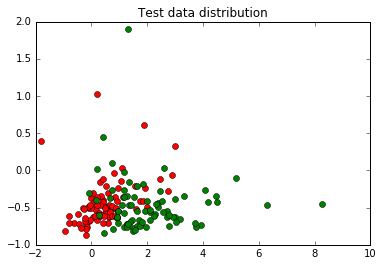

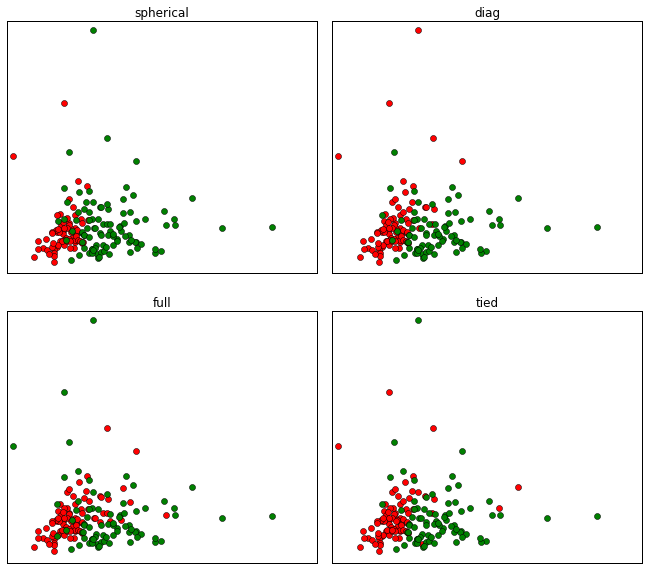

In [43]:
from sklearn.mixture import GMM
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold

#Try GMMs with different types of covariances
# How to find the best n_components
classifiers = dict((covar_type, GMM(n_components=2, covariance_type=covar_type, init_params='wc', n_iter=20)) 
                   for covar_type in ['spherical', 'diag', 'tied', 'full']);

n_classifiers = len(classifiers);

plt.figure(figsize = (6, 4));
for n, color in enumerate('rg'):
    visual = test_feature_two[test_target_two == n];
    plt.plot(visual[:, 0], visual[:, 1], 'o', color=color);
    
plt.title("Test data distribution");


plt.figure(figsize=(3 * n_classifiers * 0.75, 8));
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05, left=.01, right=.99);

for index, (name, clf) in enumerate(classifiers.items()):
    # Since we have class labels for the training data, 
    # we can initialize the GMM parameters in a supervised manner.
    print (name, clf);
    
    clf.means_ = np.array([train_feature_two[train_target_two == user].mean(axis=0) for user in subjects_two]);

    # means_ : array, shape (n_components, n_features) Mean parameters for each mixture component.
    # axis : Axis or axes along which the means are computed. The default is to compute the mean of the flattened array. 
    # If this is a tuple of ints, a mean is performed over multiple axes, instead of a single axis or all the axes as before.
    # Compute the mean of features of every user seperately
    
    # Train the other parameters using the EM algorithm
    clf.fit(train_feature_two);
    
    plt.subplot(2, n_classifiers/2, index+1); # subplot(nrows, ncols, plot_number)
    
    train_pred = clf.predict(train_feature_two);
    test_pred = clf.predict(test_feature_two);
    train_accuracy = np.mean(train_pred == train_target_two)*100;
    test_accuracy = np.mean(test_pred == test_target_two)*100;
    print ("Train_accuracy", train_accuracy);
    print ("Test_accuracy", test_accuracy);

    # Visualization of the result
#     for n, color in enumerate('r'):
#         visual_test = test_feature_two[test_pred == n];
#         print visual_test.shape;
#         plt.plot(visual_test[0:40,0], 'o', color=color);   
    
    for n, color in enumerate('rg'):
        visual_test = test_feature_two[test_pred == n];
        print visual_test.shape;
        plt.plot(visual_test[:,0], visual_test[:,1], 'o', color=color);      
    
    plt.xticks(());
    plt.yticks(());
    plt.title(name);
     

In [ ]:
train_target_user, train_feature_user, test_target_user, test_feature_user = pre_process(data_user[0], 5, True);

n_components_range = range(1, 51); ## range of numcomponents
covariances=['spherical', 'diag', 'full', 'tied'];
color_list = ['k', 'r', 'g', 'b'];
plt.figure(figsize=(16,16));
spl_1 = plt.subplot(2,1,1);
plt.title('AIC score per model');
spl_2 = plt.subplot(2,1,2);
plt.title('BIC score per model');
plt.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.2);

aic_min, bic_min, aic_max, bic_max, index = np.infty, np.infty, -np.infty, -np.infty, 1;
bars_aic, bars_bic = [], [];

for index, (covar_type, color) in enumerate(zip(covariances, color_list)):
    AIC, BIC = [], [];
    for i in n_components_range:
        gmm = GMM(n_components=i, covariance_type=covar_type);
        gmm.fit(train_feature_user);
        AIC.append(gmm.aic(train_feature_user));
        BIC.append(gmm.bic(train_feature_user));
    
    if aic_min > min(AIC):
        print 'aic_min: ', aic_min, ' new min: ', min(AIC);
        aic_min = min(AIC);
        minpos_aic = AIC.index(aic_min)+1;
        covar_aic = covar_type;
    if bic_min > min(BIC):
        print 'bic_min: ', bic_min, ' new min: ', min(BIC);
        bic_min = min(BIC);
        minpos_bic = BIC.index(bic_min)+1;
        covar_bic = covar_type;
    if aic_max < max(AIC):
        aic_max = max(AIC);
    if bic_max < max(BIC):
        bic_max = max(BIC);
    
    spl_1.plot(n_components_range, AIC, '--', color=color, label=covar_type);
    spl_2.plot(n_components_range, BIC, '--', color=color, label=covar_type);
#     xpos_aic = np.array(n_components_range)+.2*index;
#     xpos_bic = np.array(n_components_range)+.2*index;
#     bars_aic.append(spl_1.bar(xpos_aic, AIC, width=.2, color=color));
#     bars_bic.append(spl_2.bar(xpos_bic, BIC, width=.2, color=color));

plt.xticks(n_components_range);
spl_1.text(minpos_aic, aic_min*0.97+.03*aic_max, 'n_components: '+str(minpos_aic)
           +' covar_type: ' + covar_aic + ' aic: ' + str(aic_min), fontsize=14);
spl_2.text(minpos_bic, bic_min*0.97+.03*bic_max, 'n_components: '+str(minpos_bic)
           +' covar_type: ' + covar_bic + ' bic: ' + str(bic_min), fontsize=14);
# spl_1.legend(loc='upper left');
# spl_2.legend(loc='upper left');
plt.legend(covariances, loc='upper left');


# What has happened is that [[]] is a one-element list containing an empty list, 
# so all three elements of [[]] * 3 are references to this single empty list. 
# Modifying any of the elements of lists modifies this single list.

#     plt.subplot(2,2,index);
#     plt.plot(np.arange(1,num_components+1), AIC, '--k', label = "AIC");
#     plt.plot(np.arange(1,num_components+1), BIC, '--m', label = "BIC");
#     plt.xlabel("n.components");
#     plt.ylabel("information criterion");
#     plt.title(covar_type);
#     index+=1;

sklearn.cross_validation.KFold(n=400, n_folds=5, shuffle=True, random_state=None)
aic_min:  inf  new min:  4455.67382223
bic_min:  inf  new min:  9559.78736509
aic_min:  4455.67382223  new min:  2671.15180132
bic_min:  9559.78736509  new min:  7521.37666553


### Main Part for the Experiment
* Set the experiment configuration. Evaluate the effectiveness of the model by ERR directly.

In [32]:
import random;
from time import clock;

n_components_range = range(1, 51); ## num_components: 1~50
K_range = np.arange(0.01, 2.01, 0.02); ## 0.01~1.99, variance is 0.02
color_list = ['k', 'r', 'g', 'b'];
covariances=['spherical', 'diag', 'full', 'tied'];

for index_user in range(0, 11): ## Try the first 10 user
    print 'Processing on User ', index_user;
    
    plt.figure(figsize=(10,10)); ## One picture per user
    plt.title("ERR Estimation for User " + str(index_user));

    trainTarget, trainSet, testTarget, testSet = pre_process(data_user[index_user], 2, True);
    imposterSet = np.concatenate((imposter_features[0:index_user], imposter_features[index_user+1:])).reshape(250, 28);
    
    genuine_user = np.array(testSet);
    imposter_user = imposterSet;
    loo = cross_validation.LeaveOneOut(len(trainSet)); ## LOOM method iterator

    # Grid search on K, covar_type, n_components (Implemented by myself)
    for index, (covar_type, color) in enumerate(zip(covariances, color_list)):
        print "Covar_type: ", covar_type;
        ERR = [];
        start = clock();
        
        for num_components in n_components_range:
            model = GMM(n_components=num_components, covariance_type=covar_type, init_params='wc', n_iter=20);
            
            optimal_k = 0; ## LOOM K value at ERR point
            
            ## LOOM Method
            Scores = [];
            for train_index, test_index in loo:
                train, test = trainSet[train_index], trainSet[test_index];
                model.fit(train);
                Scores.append(model.score(test));

            model.fit(trainSet);
            Scores = np.array(Scores).ravel();
            mean = np.mean(Scores);
            std = np.std(Scores);
            # print "mean: ", mean, " std: ", std;

            scores_imposter = [model.score(imposter_user[i].reshape(1,-1)) for i in range(len(imposter_user))];
            scores_genuine = [model.score(genuine_user[i].reshape(1,-1)) for i in range(len(genuine_user))];
            
            #Evalutation of the model
            ## FAR, FRR = [], [];
            min_err = np.infty;

            for K in K_range:
                Seq = [Scores[j] for j in range(len(Scores)) if abs(Scores[j] - mean) < K*std];
                if(not Seq):
                    threshold_user = mean - K*std;
                else:
                    threshold_user = min(Seq);

                reject, accept = 0, 0;
                ## imposter test
                for i in range(len(scores_imposter)):
                    if(scores_imposter[i] >= threshold_user):
                        accept = accept+1;

                ## genuine test
                for i in range(len(scores_genuine)):
                    if(scores_genuine[i] < threshold_user):
                        reject = reject+1;
                        
                far = (float(accept)/250.0);
                frr = (float(reject)/200.0);
                if(min_err > abs(far-frr)):
                    min_err = abs(far-frr);
                    ## err = (far, frr);
                    err = np.mean([far, frr]); ## I am not sure whether it's approprate
                    optimal_k = K;
                
                ## FAR.append(far);
                ## FRR.append(frr);
                
            ERR.append(err);
        
        finish = clock();
        print "Time interval: ", finish-start; 
        plt.plot(n_components_range, ERR, '--', color=color, label=covar_type);
        plt.text(n_components_range, ERR, 'K: '+str(optimal_k), fontsize=14);
        plt.xlabel("Num_components");
        plt.ylabel("ERR");
        plt.legend(loc='upper left');
    

Processing on User  0
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
Covar_type:  spherical
Time interval:  62.4974973467
Covar_type:  diag
Time interval:  62.9703371782
Covar_type:  full


KeyboardInterrupt: 

Error in callback <function post_execute at 0x0000000006A4BF28> (for post_execute):


TypeError: float() argument must be a string or a number

TypeError: float() argument must be a string or a number

In [ ]:
import random

train_target_user, train_feature_user, test_target_user, test_feature_user = pre_process(data_user[0], 2, True);
# train_target, train_feature, test_target, test_feature = pre_process(data, 5, True);

imposter_index = [random.randrange(400, len(train_feature), 13) for i in range(250)];
imposter_target = np.array([train_target[i] for i in imposter_index]); 
imposter_user = np.array([train_feature[i] for i in imposter_index]);
print imposter_target;

# feature_user = np.concatenate((train_feature_user, test_feature_user), axis=0);
# genuine_index = [random.randrange(0, len(feature_user), 3) for i in range(200)];
# genuine_user = np.array([feature_user[i] for i in genuine_index]);
# print "Size of train set: ", len(feature_user);
# print train_target_user;
genuine_user = np.array(test_feature_user);

print "Size of imposter_user set: ", len(imposter_user);
print "Size of genuine_user set: ", len(genuine_user);
profiles = dict((covar_type, GMM(n_components=9, covariance_type=covar_type, init_params='wc', n_iter=20)) 
                   for covar_type in covariances);

loo = cross_validation.LeaveOneOut(len(train_feature_user));
plt.figure(figsize=(16,16));

for index, (name, model) in enumerate(profiles.items()):
#     model = profiles["diag"]
    Scores = [];
    print model;
    for train_index, test_index in loo:
        train, test = train_feature_user[train_index], train_feature_user[test_index];
        model.fit(train);
        Scores.append(model.score(test));

    model.fit(train_feature_user);
    print "Size of train set: ", len(train_feature_user);
    Scores = np.array(Scores).ravel();
    mean = np.mean(Scores);
    std = np.std(Scores);
    print "mean: ", mean, " std: ", std;
    
    #Evalutation of the model
    FAR, FRR = [], [];
    K = [float(i)/100 for i in range(1, 101)];
    print K;
    
    for k_index in range(100):
        threshold_user = min([Scores[j] for j in range(len(Scores)) if abs(Scores[j]-mean) < K[k_index]*std]);
        reject, accept = 0, 0;
        for i in range(len(imposter_user)):
            if(model.score(imposter_user[i].reshape(1,-1)) >= threshold_user):
                accept = accept+1;

        for i in range(len(genuine_user)):
            if(model.score(genuine_user[i].reshape(1,-1)) < threshold_user):
                reject = reject+1;

        FAR.append(float(accept)/250.0);
        FRR.append(float(reject)/200.0);
        
    plt.subplot(2, 2, index+1); #subplot(nrows, ncols, plot_number)
    plt.plot(K, FAR, '--k', label = "FAR");
    plt.plot(K, FRR, '--m', label = "FRR");
    plt.xlabel("K");
    plt.ylabel("FAR & FRR");
    plt.title("Model Estimation (covar_type: " + name + ")");
    
plt.legend(loc='lower right');## What's the legend function's meaning

## Demonstration of Verification System
* Use HTML and Javascript build a front end page to simulate the login page of authentication system. Record what the user types in and extract keystroke features. (Front-End: HTML + Javascript)

* Back-end receive the keystroke information and pre-process it (Filter the mistake and extract the features in proper format). Use the model built with GMM+LOOM to verify the user. (Python)

* Back-end passes the verification result to front-end. Front-end visualizes the result whether user's authentication is successful.

### Verify user's identity with feature vector and GMM+LOOM
* This is the core part of our demostration. We will use the model built by GMM+LOOM to verify user's identity. Feature vector is generated by the information extracted in the front-end. 
* Let model training be functional. This part should include setting parameter automative.
* The two following functions are for verification. "train_Model_GMM_LOOM" trains the GMM model and gets the LOOM threshold. It return a model and a threshold as a profile for a user.
* "make_Authentication" uses specific user's model and threshold to verify whether the input feature is below to this user. Means doing the authentication.

In [8]:
def train_Model_GMM_LOOM(train_data, k):
    ## TODO
#     n_components = ..
#     covariance_type= ..
#     init_params = ..
#     n_iter = ..
    ## Set the paramter of GMM model (How to find the optimal value automatively)
    
    model = GMM(n_components=20, covariance_type="diag", init_params='wc', n_iter=20);
    
    ##LOOM Method
    loo = cross_validation.LeaveOneOut(len(train_data));
    print(len(train_data));
    Scores = [];
    for train_index, test_index in loo:
        train, test = train_data[train_index], train_data[test_index];
        model.fit(train);
        Scores.append(model.score(test));
    
    Scores = np.array(Scores).ravel();
    mean = np.mean(Scores); std = np.std(Scores);
    threshold = min([Scores[i] for i in range(len(Scores)) if abs(Scores[i]-mean) < k*std]);
    
    ##Train the GMM model
    model.fit(train_data);
    profile = dict({'model': model, 'threshold': threshold});
    return profile;

def make_Authentication(model, threshold, feature):
    print feature;
    score = model.score(feature);
    print score;
    ## Normal return in ordinary situation
#     if(score < threshold):
#         return False;
#     else:
#         return True;
    
    ## This kind of return contains more information. It is only for demo and testing phase
    if(score < threshold):
        return [False, score[0], threshold];
    else:
        return [True, score[0], threshold];
    

### Demo Initialization

* Initialize the basic setting of the demo. Including: data structure for the key event (KeyEvent); profiles for initial users (Profiles); the lists which saves keyevent information.

In [9]:
from IPython.display import HTML

## Use this class to record the keystroke information from the front-end (Javascript)
class KeyEvent:
    keyCount = 0;
    
    def __init__(self, index, key, which, time_D, time_U):
        self.index = index; ## The index of pressing sequence
        self.key = key; 
        self.which = which; ## Keycode
        self.time_D = time_D;
        self.time_U = time_U;
        KeyEvent.keyCount += 1;

## save the keystroke information
Username_index, Username_key, Username_which, Username_time_D, Username_time_U = [], [], [], [], [];
Password_index, Password_key, Password_which, Password_time_D, Password_time_U = [], [], [], [], [];

## organize keystroke information into a dictionary. Now seems useless
Username_keyMap, Password_keyMap = {}, {}; 

username, password = str(), str(); ## username and password which user uses in the front-end
Profiles = dict({}); ## Store users' profiles in Demo

for i in range(5):
    train_target, train_feature, test_target, test_feature = pre_process(data_user[i], 2, True);
    print type(train_feature), train_feature.shape;
    Profiles['User'+str(i)] = {"Password": ".tie5roanl",
                               "Profile": train_Model_GMM_LOOM(train_feature, 0.35)};

print type(Profiles), len(Profiles), Profiles['User0']['Profile']['model'];

sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
<type 'numpy.ndarray'> (200L, 28L)
200
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
<type 'numpy.ndarray'> (200L, 28L)
200
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
<type 'numpy.ndarray'> (200L, 28L)
200
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
<type 'numpy.ndarray'> (200L, 28L)
200
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
<type 'numpy.ndarray'> (200L, 28L)
200
<type 'dict'> 5 GMM(covariance_type='diag', init_params='wc', min_covar=0.001,
  n_components=20, n_init=1, n_iter=20, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


### Front-End (HTML+Javascript)
   The front-end of this demo is written by html and javascript. For the convinence, I integrate the front-end code in notebook. With integrating back-end and front-end in one notebook, we can easily tune the algorithm and find the implicit problems in our system

In [10]:

%%html
<head>
    <meta http-equiv="Content-Type" content="text/html; charset=ISO-8859-1"/>
    <title>Keystroke demo</title>
    <script type="text/javascript" src="WebContent/js/UI.js"></script>
    <script type="text/javascript" src="WebContent/js/demo.js"></script>
    <link rel="stylesheet" type="text/css" href="WebContent/css/style_notebook.css"/>
</head>

<body id="body_inside">
    <h1 id="h1">Keystroke Demo</h1>
    <div class="target">
        <fieldset class="input">
            <label for="username" >Username:</label>
            <input id="username" type="text">
        </fieldset>
    
        <fieldset class="input">
            <label for="password">Password:</label>
            <input id="password" type="text">
        </fieldset>
    
        <button id="sign up">Sign up</button>
        <button id="login" onclick="exec_code()">Login</button>
    </div>
    
    <h2 id="h2">The Record Information</h2>
    
    <div class="print-output">
        <fieldset class="output">
            <label for="username-typed">Username-typed:</label>            
            <input id="username-typed" type="text" size="50"><br>
            <label for="password-typed">Password-typed:</label>            
            <input id="password-typed" type="text" size="50"><br>
            <label for="result-backend">Result-backend:</label>            
            <input id="result-backend" type="text" size="50"><br>
        </fieldset>
    </div>
    
    <script type="text/Javascript">
        var kernel = IPython.notebook.kernel;
        
        function handle_output(out) {
            console.log("here");
            console.log(out);
            var res = null, text = null;
             // if output is a print statement
            if(out.msg_type == "stream") {
                console.log("stream");
                res = out.content.text;
                console.log(res);
            }
            
            // if output is a python object
            else if(out.msg_type === "execute_result") {
                console.log("execute_result");
                res = out.content.data["text/plain"];
                if(res.length > 1) {
                    var content = res.replace(/\[|\]/g, ''); //'g' means global match
                    console.log(content);
                    content = content.split(',');
                    res = content[0];
                    var score = content[1], threshold = content[2];
                }
                console.log(typeof res);
                console.log(res);
                switch(res) {
                    case "True": //authentication successful
                        console.log(res);
                        text = "Congratulation! Authentication succeeded"
                        res = "score: " + score + '; threshold: ' + threshold;
                        break;
                    
                    case "False": //keystroke authentication failed
                        console.log(res);
                        text = "Oh... Keystroke Authentication failed! Who r u +_+";
                        res = "score: " + score + '; threshold: ' + threshold;
                        break;
                    
                    case '2': //Can not find the user
                        console.log(res);
                        text = "Can't find this user";
                        break;
                    
                    case '3': //Password is wrong
                        console.log(res);
                        text = "Password is not correct";
                        break;
                    default:
                        text = "The result from the back-end is not recognized"
                        break;
                }
                alert(text);
            }
            
            // if output is a python error
            else if(out.msg_type === "pyerr") {
                console.log("pyeer");
                res = out.content.ename + ": " + out.content.evalue;
            }
            // if output is something we haven't thought of
            else {
                res = "[out type not implemented]";   
            }
            console.log(typeof res);
            document.getElementById("result-backend").value = res;
        }
        
        function exec_code() {
            document.getElementById("username-typed").value = Username_text;
            document.getElementById("password-typed").value = Password_text;
            
            // extract username and password
            kernel.execute("username = '" + document.getElementById("username").value + "'");
            kernel.execute("password = '" + document.getElementById("password").value + "'");
            
            // extract keystroke feature
            kernel.execute("Username_index, Username_key, Username_which, Username_time_D, Username_time_U, Username_keyevent = [], [], [], [], [], [];");
            kernel.execute("Password_index, Password_key, Password_which, Password_time_D, Password_time_U, Password_keyevent = [], [], [], [], [], [];");
            
            for(i = 0; i < Feature_Username.length; i++) {
                var command_index = "Username_index.append(" + Feature_Username[i].index + ")";
                var command_key = "Username_key.append('" + Feature_Username[i].key + "')";
                var command_which = "Username_which.append(" + Feature_Username[i].which + ")";
                var command_time_D = "Username_time_D.append(" + Feature_Username[i].time_D + ")";
                var command_time_U = "Username_time_U.append(" + Feature_Username[i].time_U + ")";
                
                console.log("Executing Command: " + command_index + command_key + command_which
                            + command_time_D + command_time_U);
                kernel.execute(command_index);
                kernel.execute(command_key);
                kernel.execute(command_which);
                kernel.execute(command_time_D);
                kernel.execute(command_time_U);
            }
            kernel.execute("Username_keyMap = {'index': Username_index, 'key': Username_key, 'which': Username_which, 'time_D': Username_time_D, 'time_U': Username_time_U}");
            
            for(i = 0; i < Feature_Password.length; i++) {
                var command_index = "Password_index.append(" + Feature_Password[i].index + ")";
                var command_key = "Password_key.append('" + Feature_Password[i].key + "')";
                var command_which = "Password_which.append(" + Feature_Password[i].which + ")";
                var command_time_D = "Password_time_D.append(" + Feature_Password[i].time_D + ")";
                var command_time_U = "Password_time_U.append(" + Feature_Password[i].time_U + ")";
                
                console.log("Executing Command: " + command_index + command_key + command_which
                            + command_time_D + command_time_U);
                kernel.execute(command_index);
                kernel.execute(command_key);
                kernel.execute(command_which);
                kernel.execute(command_time_D);
                kernel.execute(command_time_U);
                
            }
            kernel.execute("Password_keyMap = {'index': Password_index, 'key': Password_key, 'which': Password_which, 'time_D': Password_time_D, 'time_U': Password_time_U}"); 
            
            //Deal with the authentication result returned from python back-end
            var callbacks = {'iopub': {'output' : handle_output}};
            kernel.execute("authentication_Main()", callbacks, {silent:false});
            console.log("button pressed");
        }
    </script>
    
</body>

### Extract and generate feature vector from the what user types in the front-end
   * Extract four kinds of keystroke feature: hold-time, DDKL, UDKL, UUKL. Feature vector stands for user's typing habit behavior. 
   
   
   * One important point is that, the sequence of key-press and key-release could be a chaos. So we should generate thefeature vector with a predefine format. This format depends on user's true username and password
   
   
   * The function "RemoveMistake" is used for the user's typing mistake. Typing mistake means the mistake that users make while typing their username and password. Generally, if users make some typing mistakes, they will delete mistakes and type in again.
   
   
   * So we should filter the typing mistakes and extract the effective typed charactors. (Attentation!! "Enter" is printable)
   
   
   * The function below: "extract_Feature", is able to remove the redundency in the data. Get keys which contain the keystroke feature's information

In [11]:
import string

def isPrintable(text):
    printset = set(string.printable);
    return set(text).issubset(printset);

def RemoveMistake(Content):
    ## Deal with typing mistake and generate feature vector
    ## Backspace: 
    length = len(Content);
    i = 0;
    while(i < length):
        item = Content[i];
        if(item.which == 8):
            ## remove Backspace and other keys that user deletes because of mistake
            ## if find a Backspace, delete the Backspace and the key in front of it
            ## additional Backspace: only remove Backspace
            if(i == 0):
                del Content[i];
                length -= 1;
                i -= 1;
            ## remove the Backspace and wrong characters
            else:
                ## remove all the other non-printable char before the Backspace
                while(not isPrintable(Content[i-1].key)):
                    del Content[i-1];
                    i -= 1; length -= 1;
                    
                ## remove the printable char that should be remove by this Backspace    
                del Content[i-1:i+1];
                length -= 2;
                i -= 2;
        i += 1;
        
## After removing the typing mistakes, the text still may have lots of redundancy. 
## Like continuous 'Shift (which:16)', non-printable charactors at the begining and the end.
## This function help us to remove those redundancy and extract the correct charcators containing the feature information

def extract_Feature(Press_Sequence, Reference):## Reference means the correct username or password
    Feature = [];
    i = len(Press_Sequence)-1;
    j = len(Reference)-1;
#     i,j = 0,0;
    ## match the sequence from the backward
#     while(i < len(Press_Sequence) and j < len(Reference)):
    while(i >= 0 and j >= 0):
        if(Press_Sequence[i].key == Reference[j]):
            ## if the char is in upper case, and the previous pressed key is 'shift'
            ## if so, take the 'shift' into the feature vector
#             print Press_Sequence[i].key;
            if(Press_Sequence[i].key.isupper() and Press_Sequence[i-1].which == 16):
                print Press_Sequence[i].key;
                Feature.append(Press_Sequence[i-1]);

            Feature.append(Press_Sequence[i]);
#             j += 1;
            j -= 1;
        i -= 1;
#         i += 1;
    
#     Feature.reverse();
    return Feature;


### Main function of back-end
* The whole procedure and all the functions of authentication demo are integrated in this main function. When user tries to login from the front-end, the front-end will triger this main function to operate authentication.


* Function "authentication_Main" is the main function of the back-end. It will use the information from the front-end to make the final decision and send it back to front-end. At last, front-end will visualize the final result to users.

In [12]:
def authentication_Main():
    ## TODO: in real case, this part should search in database
    ## In demo, this part only search in the dictionary "Profiles" which contains users' information 
    
    if(not Profiles.has_key(username)):
        print "This user doesn't exist";
        return 2;
    elif(Profiles[username]["Password"] != password):
        print "Password is not correct";
        return 3;

    Username = username;
    Password = password;
    ## Password.append("Enter"); ## Because we should let the password be compatible with CMU password
    
    Username_keyevent = [KeyEvent(Username_index[i], Username_key[i], Username_which[i],
                     Username_time_D[i], Username_time_U[i]) for i in range(len(Username_index))];

    Password_keyevent = [KeyEvent(Password_index[i], Password_key[i], Password_which[i],
                     Password_time_D[i], Password_time_U[i]) for i in range(len(Password_index))];

    ## Deal with typing mistake and generate feature vector
    ## sort by pressed index. The orginal vector is in sequence of release
    Press_Sequence_Username = sorted(Username_keyevent, key=lambda keyevent: keyevent.index);
    Press_Sequence_Password = sorted(Password_keyevent, key=lambda keyevent: keyevent.index);
    
    RemoveMistake(Press_Sequence_Username);
    RemoveMistake(Press_Sequence_Password);
    
    ## Look for user's correct password as reference according to its username
    ## The real password is used as the reference which helps us to extract the keystroke feature
    Username_Keystroke = extract_Feature(Press_Sequence_Username, Username);
    Password_Keystroke = extract_Feature(Press_Sequence_Password, Password);

    ## Generate feature vectors for each sub-feature, 
    ## four kinds of sub-features: hold-time, DDKL, UDKL, UUKL
    H_time_Username = [(Username_Keystroke[i].time_U - Username_Keystroke[i].time_D)/1000
                       for i in range(len(Username_Keystroke))];
    H_time_Password = [(Password_Keystroke[i].time_U - Password_Keystroke[i].time_D)/1000 
                       for i in range(len(Password_Keystroke))];

    DDKL_Username = [(Username_Keystroke[i+1].time_D - Username_Keystroke[i].time_D)/1000 
                     for i in range(len(Username_Keystroke)-1)];
    DDKL_Password = [(Password_Keystroke[i+1].time_D - Password_Keystroke[i].time_D)/1000
                     for i in range(len(Password_Keystroke)-1)];

    UDKL_Username = [(Username_Keystroke[i+1].time_D - Username_Keystroke[i].time_U)/1000 
                     for i in range(len(Username_Keystroke)-1)];
    UDKL_Password = [(Password_Keystroke[i+1].time_D - Password_Keystroke[i].time_U)/1000 
                     for i in range(len(Password_Keystroke)-1)];

    UUKL_Username = [(Username_Keystroke[i+1].time_U - Username_Keystroke[i].time_U)/1000
                     for i in range(len(Username_Keystroke)-1)];
    UUKL_Password = [(Password_Keystroke[i+1].time_U - Password_Keystroke[i].time_U)/1000 
                     for i in range(len(Password_Keystroke)-1)];
    
    ## Feature_Vector is the final feature vector which is used to verify user's keystroke
    ## Generate feature's vector used for authentication
    Feature_Vector = [];
    for i in range(len(H_time_Password)):
        Feature_Vector.append(H_time_Password[i]);
        if(i < len(DDKL_Password)):
            Feature_Vector.append(DDKL_Password[i]);
            Feature_Vector.append(UDKL_Password[i]);

    ## Make the keystroke authentication
#     print "Make authentication";    
#     if(make_Authentication(Profiles[Username]['Profile']['model'], 
#                            Profiles[Username]['Profile']['threshold'], 
#                            np.array(Feature_Vector).reshape(1,-1))):
#         return 0;
#     else:
#         return 1;

    ## For demo and testing phase
    result = make_Authentication(Profiles[Username]['Profile']['model'], 
                           Profiles[Username]['Profile']['threshold'], 
                           np.array(Feature_Vector).reshape(1,-1));
    return result;
    

### Test 
* The following parts are for testing the functions.


* Pre-process the typing data collected from the front-end. Including removing typing mistakes and arranging it in press sequence.

In [100]:
##Deal with the features extracted by the front-end

print len(Username_index), Username_index;
print len(Username_key), Username_key;
print len(Username_which), Username_which;
print len(Username_time_D), Username_time_D;
print len(Username_time_U), Username_time_U;

print len(Password_index), Password_index;
print len(Password_key), Password_key;
print len(Password_which), Password_which;
print len(Password_time_D), Password_time_D;
print len(Password_time_U), Password_time_U;

Username_keyevent = [KeyEvent(Username_index[i], Username_key[i], Username_which[i], 
                     Username_time_D[i], Username_time_U[i]) for i in range(len(Username_index))];

Password_keyevent = [KeyEvent(Password_index[i], Password_key[i], Password_which[i], 
                     Password_time_D[i], Password_time_U[i]) for i in range(len(Password_index))];

## Deal with typing mistake and generate feature vector
## sort by pressed index. The orginal vector is in sequence of release
Press_Sequence_Username = sorted(Username_keyevent, key=lambda keyevent: keyevent.index);
Press_Sequence_Password = sorted(Password_keyevent, key=lambda keyevent: keyevent.index);

RemoveMistake(Press_Sequence_Username);
RemoveMistake(Press_Sequence_Password);

# print "Release Sequence";
# print [Username_keyevent[i].key for i in range(len(Username_keyevent))];
# print [Username_keyevent[i].index for i in range(len(Username_keyevent))];

# print [Password_keyevent[i].key for i in range(len(Password_keyevent))];
# print [Password_keyevent[i].index for i in range(len(Username_keyevent))];

print "Press Sequence";
print [Press_Sequence_Username[i].key for i in range(len(Press_Sequence_Username))];
print [Press_Sequence_Username[i].index for i in range(len(Press_Sequence_Username))];

print [Press_Sequence_Password[i].key for i in range(len(Press_Sequence_Password))];
print [Press_Sequence_Password[i].index for i in range(len(Press_Sequence_Password))];

6 [0, 1, 2, 3, 4, 5]
6 ['Shift', 'U', 's', 'e', 'r', '0']
6 [16, 85, 83, 69, 82, 48]
6 [24330759.63, 24330976.590000004, 24331191.89, 24331384.03, 24331544.080000002, 24331768.240000002]
6 [24331007.575000003, 24331047.410000004, 24331279.425, 24331463.535000004, 24331615.515, 24331839.570000004]
10 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
10 ['.', 't', 'i', 'e', '5', 'r', 'o', 'a', 'n', 'l']
10 [190, 84, 73, 69, 53, 82, 79, 65, 78, 76]
10 [24333672.330000002, 24333855.625000004, 24334007.405, 24334207.570000004, 24334648.135, 24334968.175, 24335167.725, 24335319.665000003, 24335464.005000003, 24335656.040000003]
10 [24333743.65, 24333935.330000002, 24334071.27, 24334279.430000003, 24334719.41, 24335047.630000003, 24335247.325, 24335407.575, 24335527.525000002, 24335719.240000002]
Press Sequence
['Shift', 'U', 's', 'e', 'r', '0']
[0, 1, 2, 3, 4, 5]
['.', 't', 'i', 'e', '5', 'r', 'o', 'a', 'n', 'l']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [101]:

## Generate the format of feature vector. We build the feature vector according to the format of CMU dataset (H, DD, UD...)
## In the next step, we will calculate each feature's value and fill this vector with those values
## 
Username = "Amadeus"
Password = ".tie5roanl"
# Username = [User[i] for i in range(len(User))];
# Password = [PWD[i] for i in range(len(PWD))];

# Password.append("Enter");

Username_Keystroke = extract_Feature(Press_Sequence_Username, Username);
Password_Keystroke = extract_Feature(Press_Sequence_Password, Password);

print [Username_Keystroke[i].key for i in range(len(Username_Keystroke))];
print [Password_Keystroke[i].key for i in range(len(Password_Keystroke))];

## Generate feature vector, four kinds of features: hold-time, DDKL, UDKL, UUKL
H_time_Username = [(Username_Keystroke[i].time_U - Username_Keystroke[i].time_D)/1000
                   for i in range(len(Username_Keystroke))];
H_time_Password = [(Password_Keystroke[i].time_U - Password_Keystroke[i].time_D)/1000 
                   for i in range(len(Password_Keystroke))];

DDKL_Username = [(Username_Keystroke[i+1].time_D - Username_Keystroke[i].time_D)/1000 
                 for i in range(len(Username_Keystroke)-1)];
DDKL_Password = [(Password_Keystroke[i+1].time_D - Password_Keystroke[i].time_D)/1000
                 for i in range(len(Password_Keystroke)-1)];

UDKL_Username = [(Username_Keystroke[i+1].time_D - Username_Keystroke[i].time_U)/1000 
                 for i in range(len(Username_Keystroke)-1)];
UDKL_Password = [(Password_Keystroke[i+1].time_D - Password_Keystroke[i].time_U)/1000 
                 for i in range(len(Password_Keystroke)-1)];

UUKL_Username = [(Username_Keystroke[i+1].time_U - Username_Keystroke[i].time_U)/1000
                 for i in range(len(Username_Keystroke)-1)];
UUKL_Password = [(Password_Keystroke[i+1].time_U - Password_Keystroke[i].time_U)/1000 
                 for i in range(len(Password_Keystroke)-1)];

print len(H_time_Password), H_time_Password;
print len(DDKL_Password), DDKL_Password;
print len(UDKL_Password), UDKL_Password;
print len(UUKL_Password), UUKL_Password;

Feature_Vector = [];
for i in range(len(H_time_Password)):
    Feature_Vector.append(H_time_Password[i]);
    if(i < len(DDKL_Password)):
        Feature_Vector.append(DDKL_Password[i]);
        Feature_Vector.append(UDKL_Password[i]);
    
print "Length of Feature Vector: ", len(Feature_Vector);
print Feature_Vector;


[]
['.', 't', 'i', 'e', '5', 'r', 'o', 'a', 'n', 'l']
10 [0.07131999999657274, 0.07970499999821186, 0.06386499999836087, 0.07185999999940396, 0.07127499999850988, 0.07945500000193716, 0.07959999999776482, 0.08790999999642372, 0.06351999999955296, 0.06319999999925494]
9 [0.18329500000178814, 0.1517799999974668, 0.20016500000283122, 0.44056499999761584, 0.32003999999910593, 0.19955000000074505, 0.1519400000013411, 0.14433999999985098, 0.192035000000149]
9 [0.1119750000052154, 0.07207499999925494, 0.13630000000447035, 0.3687049999982119, 0.24876500000059604, 0.1200949999988079, 0.07234000000357628, 0.056430000003427266, 0.12851500000059604]
9 [0.19168000000342728, 0.1359399999976158, 0.2081600000038743, 0.43997999999672177, 0.3282200000025332, 0.19969499999657273, 0.16025, 0.11995000000298023, 0.19171499999985098]
Length of Feature Vector:  28
[0.07131999999657274, 0.18329500000178814, 0.1119750000052154, 0.07970499999821186, 0.1517799999974668, 0.07207499999925494, 0.06386499999836087, 0

In [102]:
profiles = [];
for i in range(5):
    train_target, train_feature, test_target, test_feature = pre_process(data_user[i], 2, True);
    print type(train_feature), train_feature.shape;
    profiles.append(train_Model_GMM_LOOM(train_feature, 0.35));
    print make_Authentication(profiles[i]['model'], profiles[i]['threshold'], np.array(Feature_Vector).reshape(1, -1));


sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
<type 'numpy.ndarray'> (200L, 28L)
200
[[ 0.07132   0.183295  0.111975  0.079705  0.15178   0.072075  0.063865
   0.200165  0.1363    0.07186   0.440565  0.368705  0.071275  0.32004
   0.248765  0.079455  0.19955   0.120095  0.0796    0.15194   0.07234
   0.08791   0.14434   0.05643   0.06352   0.192035  0.128515  0.0632  ]]
[ 49.96083296]
[True, 49.960832963260437, 44.553961316994943]
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=True, random_state=None)
<type 'numpy.ndarray'> (200L, 28L)
200
[[ 0.07132   0.183295  0.111975  0.079705  0.15178   0.072075  0.063865
   0.200165  0.1363    0.07186   0.440565  0.368705  0.071275  0.32004
   0.248765  0.079455  0.19955   0.120095  0.0796    0.15194   0.07234
   0.08791   0.14434   0.05643   0.06352   0.192035  0.128515  0.0632  ]]
[ 39.61994805]
[False, 39.61994805386761, 44.338561576953452]
sklearn.cross_validation.KFold(n=400, n_folds=2, shuffle=T